In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, Dropout, GRU
from keras.metrics import RootMeanSquaredError
from sklearn.preprocessing import MinMaxScaler

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
seed = 13520161
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
raw_train = pd.read_csv("train_LTC.csv")
test = pd.read_csv("test_LTC.csv")

raw_train = raw_train.iloc[10:] # Drop first 10 rows
train_date = raw_train["Date"]
train_date = pd.to_datetime(train_date)

train = raw_train.drop("Date", axis=1)

#train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])

print(test.head())
print(train.head())

        Date
0 2019-11-27
1 2019-11-28
2 2019-11-29
3 2019-11-30
4 2019-12-01
     Open   High    Low  Close
10  24.12  24.76  22.69  23.23
11  50.50  50.50  48.35  49.20
12  49.20  49.90  40.24  42.72
13  42.72  43.73  39.59  43.20
14  43.20  43.61  41.00  41.72


In [ ]:
raw_train.tail()

,Date,Open,High,Low,Close
375,2019-11-22,50.68,51.69,43.65,47.73
376,2019-11-23,47.73,48.64,46.41,48.28
377,2019-11-24,48.28,48.33,43.64,43.92
378,2019-11-25,43.92,47.50,42.24,45.56
379,2019-11-26,45.56,47.42,45.54,47.00


<AxesSubplot: title={'center': 'Price Over Time'}, xlabel='Date'>

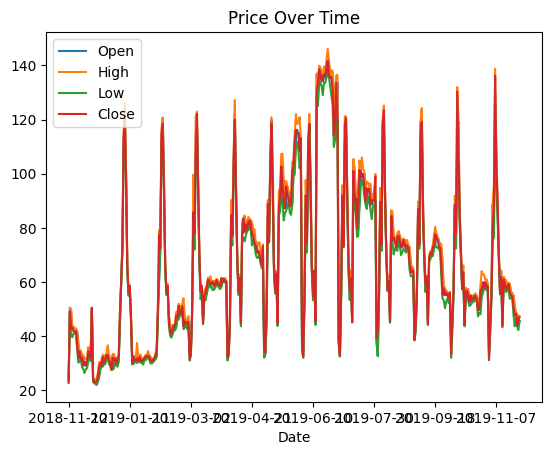

In [ ]:
raw_train.plot(x="Date", y=["Open", "High", "Low", "Close"], kind="line", title="Price Over Time")

In [ ]:
sc = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = sc.fit_transform(train)

In [ ]:
# split for getting next day result
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [ ]:
# choose a number of time steps
n_steps = [5, 10, 25, 35, 50]
# split into samples
data = []
for res in n_steps:
    data.append(split_sequence(training_set_scaled, res))

print(len(data))

2


In [ ]:
type(y[0][0])

numpy.float64

In [ ]:
print(X.shape)
print(y.shape)

(360, 10, 4)
(360, 4)


In [ ]:
model_list = []
model_history_list = []
for i in range(len(n_steps)):
    model_list.append(Sequential())
    model_list[i].add(Bidirectional(LSTM(128, input_shape=(n_steps[i], 4), return_sequences=True)))
    model_list[i].add(Dropout(0.1))
    model_list[i].add(Bidirectional(LSTM(64, input_shape=(n_steps[i], 4), return_sequences=True)))
    model_list[i].add(Dropout(0.1))
    model_list[i].add(Bidirectional(LSTM(32, input_shape=(n_steps[i], 4))))
    model_list[i].add(Dropout(0.1))
    model_list[i].add(Dense(32, activation='relu'))
    model_list[i].add(Dense(4))

    model_list[i].compile(
        optimizer="adam",
        loss="mse",
        metrics=[RootMeanSquaredError()])

    model_history_list.append(model_list[i].fit(data[i][0], data[i][1], epochs=32, batch_size=32))
    print("============================== ^^ Model 1 Timestep: " + str(n_steps[i]))

Epoch 1/32
12/12 [==============================] - 23s 80ms/step - loss: 0.0968 - root_mean_squared_error: 0.3111
Epoch 2/32
12/12 [==============================] - 1s 74ms/step - loss: 0.0491 - root_mean_squared_error: 0.2216
Epoch 3/32
12/12 [==============================] - 1s 73ms/step - loss: 0.0384 - root_mean_squared_error: 0.1959
Epoch 4/32
12/12 [==============================] - 1s 73ms/step - loss: 0.0355 - root_mean_squared_error: 0.1885
Epoch 5/32
12/12 [==============================] - 1s 73ms/step - loss: 0.0351 - root_mean_squared_error: 0.1874
Epoch 6/32
12/12 [==============================] - 1s 74ms/step - loss: 0.0303 - root_mean_squared_error: 0.1741
Epoch 7/32
12/12 [==============================] - 1s 81ms/step - loss: 0.0287 - root_mean_squared_error: 0.1695
Epoch 8/32
12/12 [==============================] - 1s 74ms/step - loss: 0.0266 - root_mean_squared_error: 0.1630
Epoch 9/32
12/12 [==============================] - 1s 73ms/step - loss: 0.0254 - root_

KeyboardInterrupt: 

In [ ]:
model_2_list = []
model_2_history_list = []
for i in range(len(n_steps)):
    model_2_list.append(Sequential())
    model_2_list[i].add(GRU(128, input_shape=(n_steps[i], 4), return_sequences=True))
    model_2_list[i].add(Dropout(0.2))
    model_2_list[i].add(GRU(64, return_sequences=True))
    model_2_list[i].add(Dropout(0.2))
    model_2_list[i].add(GRU(64))
    model_2_list[i].add(Dropout(0.2))
    model_2_list[i].add(Dense(32, activation='relu'))
    model_2_list[i].add(Dense(4))

    model_2_list[i].compile(
        optimizer="adam",
        loss="mse",
        metrics=[RootMeanSquaredError()])

    model_2_history_list.append(model_2_list[i].fit(data[i][0], data[i][1], epochs=32, batch_size=32))
    print("============================== ^^ Model 2 Timestep: " + str(n_steps[i]))

Epoch 1/32
11/11 [==============================] - 15s 271ms/step - loss: 0.0697 - root_mean_squared_error: 0.2640
Epoch 2/32
11/11 [==============================] - 3s 270ms/step - loss: 0.0340 - root_mean_squared_error: 0.1844
Epoch 3/32
11/11 [==============================] - 3s 271ms/step - loss: 0.0321 - root_mean_squared_error: 0.1793
Epoch 4/32
11/11 [==============================] - 3s 271ms/step - loss: 0.0306 - root_mean_squared_error: 0.1750
Epoch 5/32
11/11 [==============================] - 3s 271ms/step - loss: 0.0294 - root_mean_squared_error: 0.1716
Epoch 6/32
11/11 [==============================] - 3s 270ms/step - loss: 0.0285 - root_mean_squared_error: 0.1688
Epoch 7/32
11/11 [==============================] - 3s 280ms/step - loss: 0.0274 - root_mean_squared_error: 0.1654
Epoch 8/32
11/11 [==============================] - 3s 270ms/step - loss: 0.0245 - root_mean_squared_error: 0.1566
Epoch 9/32
11/11 [==============================] - 3s 271ms/step - loss: 0.023

In [ ]:
model_3_list = []
model_3_history_list = []
for i in range(len(n_steps)):
    model_3_list.append(Sequential())
    model_3_list[i].add(LSTM(128, input_shape=(n_steps[i], 4), return_sequences=True))
    model_3_list[i].add(Dropout(0.1))
    model_3_list[i].add(LSTM(64, input_shape=(n_steps[i], 4), return_sequences=True))
    model_3_list[i].add(Dropout(0.1))
    model_3_list[i].add(LSTM(32, input_shape=(n_steps[i], 4)))
    model_3_list[i].add(Dropout(0.1))
    model_3_list[i].add(Dense(32, activation='relu'))
    model_3_list[i].add(Dense(4)))

    model_3_list[i].compile(
        optimizer="adam",
        loss="mse",
        metrics=[RootMeanSquaredError()])

    model_3_history_list.append(model_3_list[i].fit(data[i][0], data[i][1], epochs=32, batch_size=32))
    print("============================== ^^ Model 2 Timestep: " + str(n_steps[i]))

Epoch 1/32
11/11 [==============================] - 18s 168ms/step - loss: 0.0810 - root_mean_squared_error: 0.2846
Epoch 2/32
11/11 [==============================] - 2s 159ms/step - loss: 0.0399 - root_mean_squared_error: 0.1997
Epoch 3/32
11/11 [==============================] - 2s 151ms/step - loss: 0.0357 - root_mean_squared_error: 0.1889
Epoch 4/32
11/11 [==============================] - 2s 150ms/step - loss: 0.0343 - root_mean_squared_error: 0.1852
Epoch 5/32
11/11 [==============================] - 2s 149ms/step - loss: 0.0326 - root_mean_squared_error: 0.1806
Epoch 6/32
11/11 [==============================] - 2s 141ms/step - loss: 0.0319 - root_mean_squared_error: 0.1785
Epoch 7/32
11/11 [==============================] - 2s 150ms/step - loss: 0.0307 - root_mean_squared_error: 0.1753
Epoch 8/32
11/11 [==============================] - 2s 150ms/step - loss: 0.0293 - root_mean_squared_error: 0.1713
Epoch 9/32
11/11 [==============================] - 2s 159ms/step - loss: 0.027

In [ ]:
predicted_data = X[:3]
res = model_list[3].predict(predicted_data)
res = sc.inverse_transform(res)

[[[0.01044211 0.01052116 0.006      0.00294737]
  [0.23258947 0.2204551  0.22913043 0.22164211]
  [0.22164211 0.21556154 0.1586087  0.16707368]
  [0.16707368 0.16523938 0.15295652 0.17111579]
  [0.17111579 0.16426066 0.16521739 0.15865263]
  [0.15865263 0.15390262 0.16573913 0.15806316]
  [0.15806316 0.15830683 0.16956522 0.15974737]
  [0.15974737 0.14990621 0.11304348 0.10972632]
  [0.10972632 0.11483566 0.07147826 0.07705263]
  [0.07705263 0.08865509 0.07913043 0.09642105]]

 [[0.23258947 0.2204551  0.22913043 0.22164211]
  [0.22164211 0.21556154 0.1586087  0.16707368]
  [0.16707368 0.16523938 0.15295652 0.17111579]
  [0.17111579 0.16426066 0.16521739 0.15865263]
  [0.15865263 0.15390262 0.16573913 0.15806316]
  [0.15806316 0.15830683 0.16956522 0.15974737]
  [0.15974737 0.14990621 0.11304348 0.10972632]
  [0.10972632 0.11483566 0.07147826 0.07705263]
  [0.07705263 0.08865509 0.07913043 0.09642105]
  [0.09642105 0.09142811 0.08095652 0.07098947]]

 [[0.22164211 0.21556154 0.1586087  

In [ ]:
sc.inverse_transform(data[3][1])

array([[30.53, 30.8 , 27.47, 27.77],
       [27.77, 33.49, 27.69, 32.05],
       [32.05, 33.38, 28.  , 30.84],
       ...,
       [48.28, 48.33, 43.64, 43.92],
       [43.92, 47.5 , 42.24, 45.56],
       [45.56, 47.42, 45.54, 47.  ]])

In [ ]:
data[3][0][-1:]

array([[[0.2688    , 0.25772775, 0.27034783, 0.25726316],
        [0.25726316, 0.24467825, 0.22008696, 0.22551579],
        [0.22551579, 0.21841612, 0.23034783, 0.22669474],
        [0.22669474, 0.28872033, 0.2266087 , 0.28741053],
        [0.28741053, 0.33113123, 0.28095652, 0.28901053],
        [0.28901053, 0.32077318, 0.29443478, 0.31183158],
        [0.31183158, 0.31971291, 0.30965217, 0.29448421],
        [0.29448421, 0.30421662, 0.31173913, 0.31191579],
        [0.31191579, 0.30617405, 0.30417391, 0.29642105],
        [0.29642105, 0.2954082 , 0.306     , 0.29978947],
        [0.08825263, 0.12910856, 0.07921739, 0.07494737],
        [0.19873684, 0.19117527, 0.16886957, 0.16606316],
        [0.28227368, 0.27681266, 0.27608696, 0.26812632],
        [0.55351579, 0.53225675, 0.46408696, 0.47772632],
        [0.46122105, 0.59155044, 0.47321739, 0.54989474],
        [0.90475789, 0.94062475, 0.90043478, 0.95477895],
        [0.72025263, 0.69276568, 0.6373913 , 0.67292632],
        [0.524

In [ ]:
current_data

array([0.2688    , 0.25772775, 0.27034783, 0.25726316, 0.25726316,
       0.24467825, 0.22008696, 0.22551579, 0.22551579, 0.21841612,
       0.23034783, 0.22669474, 0.22669474, 0.28872033, 0.2266087 ,
       0.28741053, 0.28741053, 0.33113123, 0.28095652, 0.28901053,
       0.28901053, 0.32077318, 0.29443478, 0.31183158, 0.31183158,
       0.31971291, 0.30965217, 0.29448421, 0.29448421, 0.30421662,
       0.31173913, 0.31191579, 0.31191579, 0.30617405, 0.30417391,
       0.29642105, 0.29642105, 0.2954082 , 0.306     , 0.29978947,
       0.08825263, 0.12910856, 0.07921739, 0.07494737, 0.19873684,
       0.19117527, 0.16886957, 0.16606316, 0.28227368, 0.27681266,
       0.27608696, 0.26812632, 0.55351579, 0.53225675, 0.46408696,
       0.47772632, 0.46122105, 0.59155044, 0.47321739, 0.54989474,
       0.90475789, 0.94062475, 0.90043478, 0.95477895, 0.72025263,
       0.69276568, 0.6373913 , 0.67292632, 0.52454737, 0.55452247,
       0.54721739, 0.56547368, 0.40446316, 0.39254547, 0.402  

In [ ]:
from datetime import timedelta

current_data = data[3][0][-1:]
current_date = train_date.iloc[-1]
predicted_data = []
for i in range(400):
    new_data = model_list[3].predict(current_data)
    current_date = current_date + timedelta(days=1) 
    new_data = sc.inverse_transform(new_data)[0]
    new_data = np.append(new_data, current_date)
    print(new_data)
    predicted_data.append(new_data)
    current_data = current_data[-34:] + new_data[0]

1/1 [==============================] - 0s 15ms/step
[283.4123229980469 402.0567321777344 309.8459167480469 354.1955261230469
 Timestamp('2020-02-02 00:00:00')]
1/1 [==============================] - 0s 16ms/step
[283.41082763671875 402.0576171875 309.845947265625 354.19635009765625
 Timestamp('2020-02-03 00:00:00')]
1/1 [==============================] - 0s 18ms/step
[283.40948486328125 402.05841064453125 309.8459777832031 354.1971130371094
 Timestamp('2020-02-04 00:00:00')]
1/1 [==============================] - 0s 70ms/step
[283.40826416015625 402.0591125488281 309.8459777832031 354.1977844238281
 Timestamp('2020-02-05 00:00:00')]
1/1 [==============================] - 0s 70ms/step
[283.40716552734375 402.0597839355469 309.84600830078125 354.1983947753906
 Timestamp('2020-02-06 00:00:00')]
1/1 [==============================] - 0s 19ms/step
[283.40618896484375 402.06036376953125 309.8460388183594 354.1989440917969
 Timestamp('2020-02-07 00:00:00')]
1/1 [==============================

In [ ]:
# res = pd.DataFrame(data=res, columns=["Open", "High", "Low", "Close"])
# res["Date"] = predicted_data
# res.plot(x="Date", y=["Open", "High", "Low", "Close"], kind="line", title="Predicted 

In [ ]:
res = pd.DataFrame(predicted_data, columns=["Open", "High", "Low", "Close", "Date"])
filtered_res = pd.merge(res, test, how="inner", on=["Date"])
final_res

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, Dropout, GRU
from keras.metrics import RootMeanSquaredError
from sklearn.preprocessing import MinMaxScaler

model = Sequential()
model.add(LSTM(128, input_shape=(3, 4), return_sequences=True))
model.add(Dense(32, activation='relu'))
model.add(Dense(33))

IndentationError: unexpected indent (128759862.py, line 10)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=61bb34cb-2316-475c-9595-96cf5c0e1564' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>